In [53]:
# import libraries
import pandas as pd
import numpy as np
import ast
import re
import spacy
import nltk
import warnings
nltk.download(['punkt', 'stopwords', 'wordnet', 'omw-1.4'])
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure
import gensim
from gensim import corpora
import pyLDAvis
import pyLDAvis.gensim 
from gensim.models import Nmf
from gensim.models import LsiModel
from sklearn.decomposition import LatentDirichletAllocation, NMF, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary
from wordcloud import WordCloud
%matplotlib inline


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\arwao\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\arwao\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\arwao\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\arwao\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [80]:
articles = pd.read_csv('medium_articles.csv')
articles.head()

,title,text,url,authors,timestamp,tags
0,Mental Note Vol. 24,Photo by Josh Riemer on Unsplash\n\nMerry Chri...,https://medium.com/invisible-illness/mental-no...,['Ryan Fan'],2020-12-26 03:38:10.479000+00:00,"['Mental Health', 'Health', 'Psychology', 'Sci..."
1,Your Brain On Coronavirus,Your Brain On Coronavirus\n\nA guide to the cu...,https://medium.com/age-of-awareness/how-the-pa...,['Simon Spichak'],2020-09-23 22:10:17.126000+00:00,"['Mental Health', 'Coronavirus', 'Science', 'P..."
2,Mind Your Nose,Mind Your Nose\n\nHow smell training can chang...,https://medium.com/neodotlife/mind-your-nose-f...,[],2020-10-10 20:17:37.132000+00:00,"['Biotechnology', 'Neuroscience', 'Brain', 'We..."
3,The 4 Purposes of Dreams,Passionate about the synergy between science a...,https://medium.com/science-for-real/the-4-purp...,['Eshan Samaranayake'],2020-12-21 16:05:19.524000+00:00,"['Health', 'Neuroscience', 'Mental Health', 'P..."
4,Surviving a Rod Through the Head,"You’ve heard of him, haven’t you? Phineas Gage...",https://medium.com/live-your-life-on-purpose/s...,['Rishav Sinha'],2020-02-26 00:01:01.576000+00:00,"['Brain', 'Health', 'Development', 'Psychology..."


In [81]:
articles.shape[0]

192368

### Check for duplicate articles using URL

In [82]:
articles['url'].duplicated().sum()

0

In [83]:
articles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192368 entries, 0 to 192367
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   title      192363 non-null  object
 1   text       192368 non-null  object
 2   url        192368 non-null  object
 3   authors    192368 non-null  object
 4   timestamp  192366 non-null  object
 5   tags       192368 non-null  object
dtypes: object(6)
memory usage: 8.8+ MB


# EDA

write a short paragraph here

## Most common topics in the dataset 

In [84]:
articles['tags'][3]

"['Health', 'Neuroscience', 'Mental Health', 'Psychology', 'Science']"

In [85]:
def getListValues(col, df=articles):
    '''
    INPUT:
    col - (str) column name as a string
    df - original pandas dataframe 
    OUTPUT:
    groupedList - List of lists
    
    Description:
    Return a 
    '''
    list = lambda x: ast.literal_eval(x)

    df[col] = df[col].apply(list)

    groupedList = df[col].values.tolist()

    return groupedList

In [86]:
# make list of lists
tags_list = getListValues('tags')
tags_list[:5]

[['Mental Health', 'Health', 'Psychology', 'Science', 'Neuroscience'],
 ['Mental Health', 'Coronavirus', 'Science', 'Psychology', 'Neuroscience'],
 ['Biotechnology', 'Neuroscience', 'Brain', 'Wellness', 'Science'],
 ['Health', 'Neuroscience', 'Mental Health', 'Psychology', 'Science'],
 ['Brain', 'Health', 'Development', 'Psychology', 'Science']]

In [87]:
# return unique tags
unique_values = list(set().union(*tags_list))
len(unique_values)

78638

There is around 78000 unique tags, for better visualization we're going to display the top 25 tags

In [88]:
def countValues(lists):
    '''
    INPUT:
    
    
    OUTPUT:
    
    
    Description:
    Return a 
    '''
    # count number of tags for all lists
    flat_list = [x for sublist in lists for x in sublist]

    # create new dataframe
    counts = pd.DataFrame({'counts': flat_list})

    return counts

In [89]:
tags_num = countValues(tags_list)

In [90]:
def top_n_tags(n , tags=tags_num):
    '''
    INPUT:
    tags - pandas dataframe of tags and thier count
    n - (int) number of tags you want to retrive 
    OUTPUT:
    top_tags - pandas dataframe of n tags and count
    
    Description:
    Return a list of top n tags in the dataset 
    '''
    top_tags = tags.value_counts()[:n]
    return top_tags

In [91]:
# store top 25 tags
top25 = top_n_tags(25)

In [92]:
type(top25.index)

pandas.core.indexes.multi.MultiIndex

In [93]:
# changing the format from multi-index to index
index = top25.index.map(''.join)

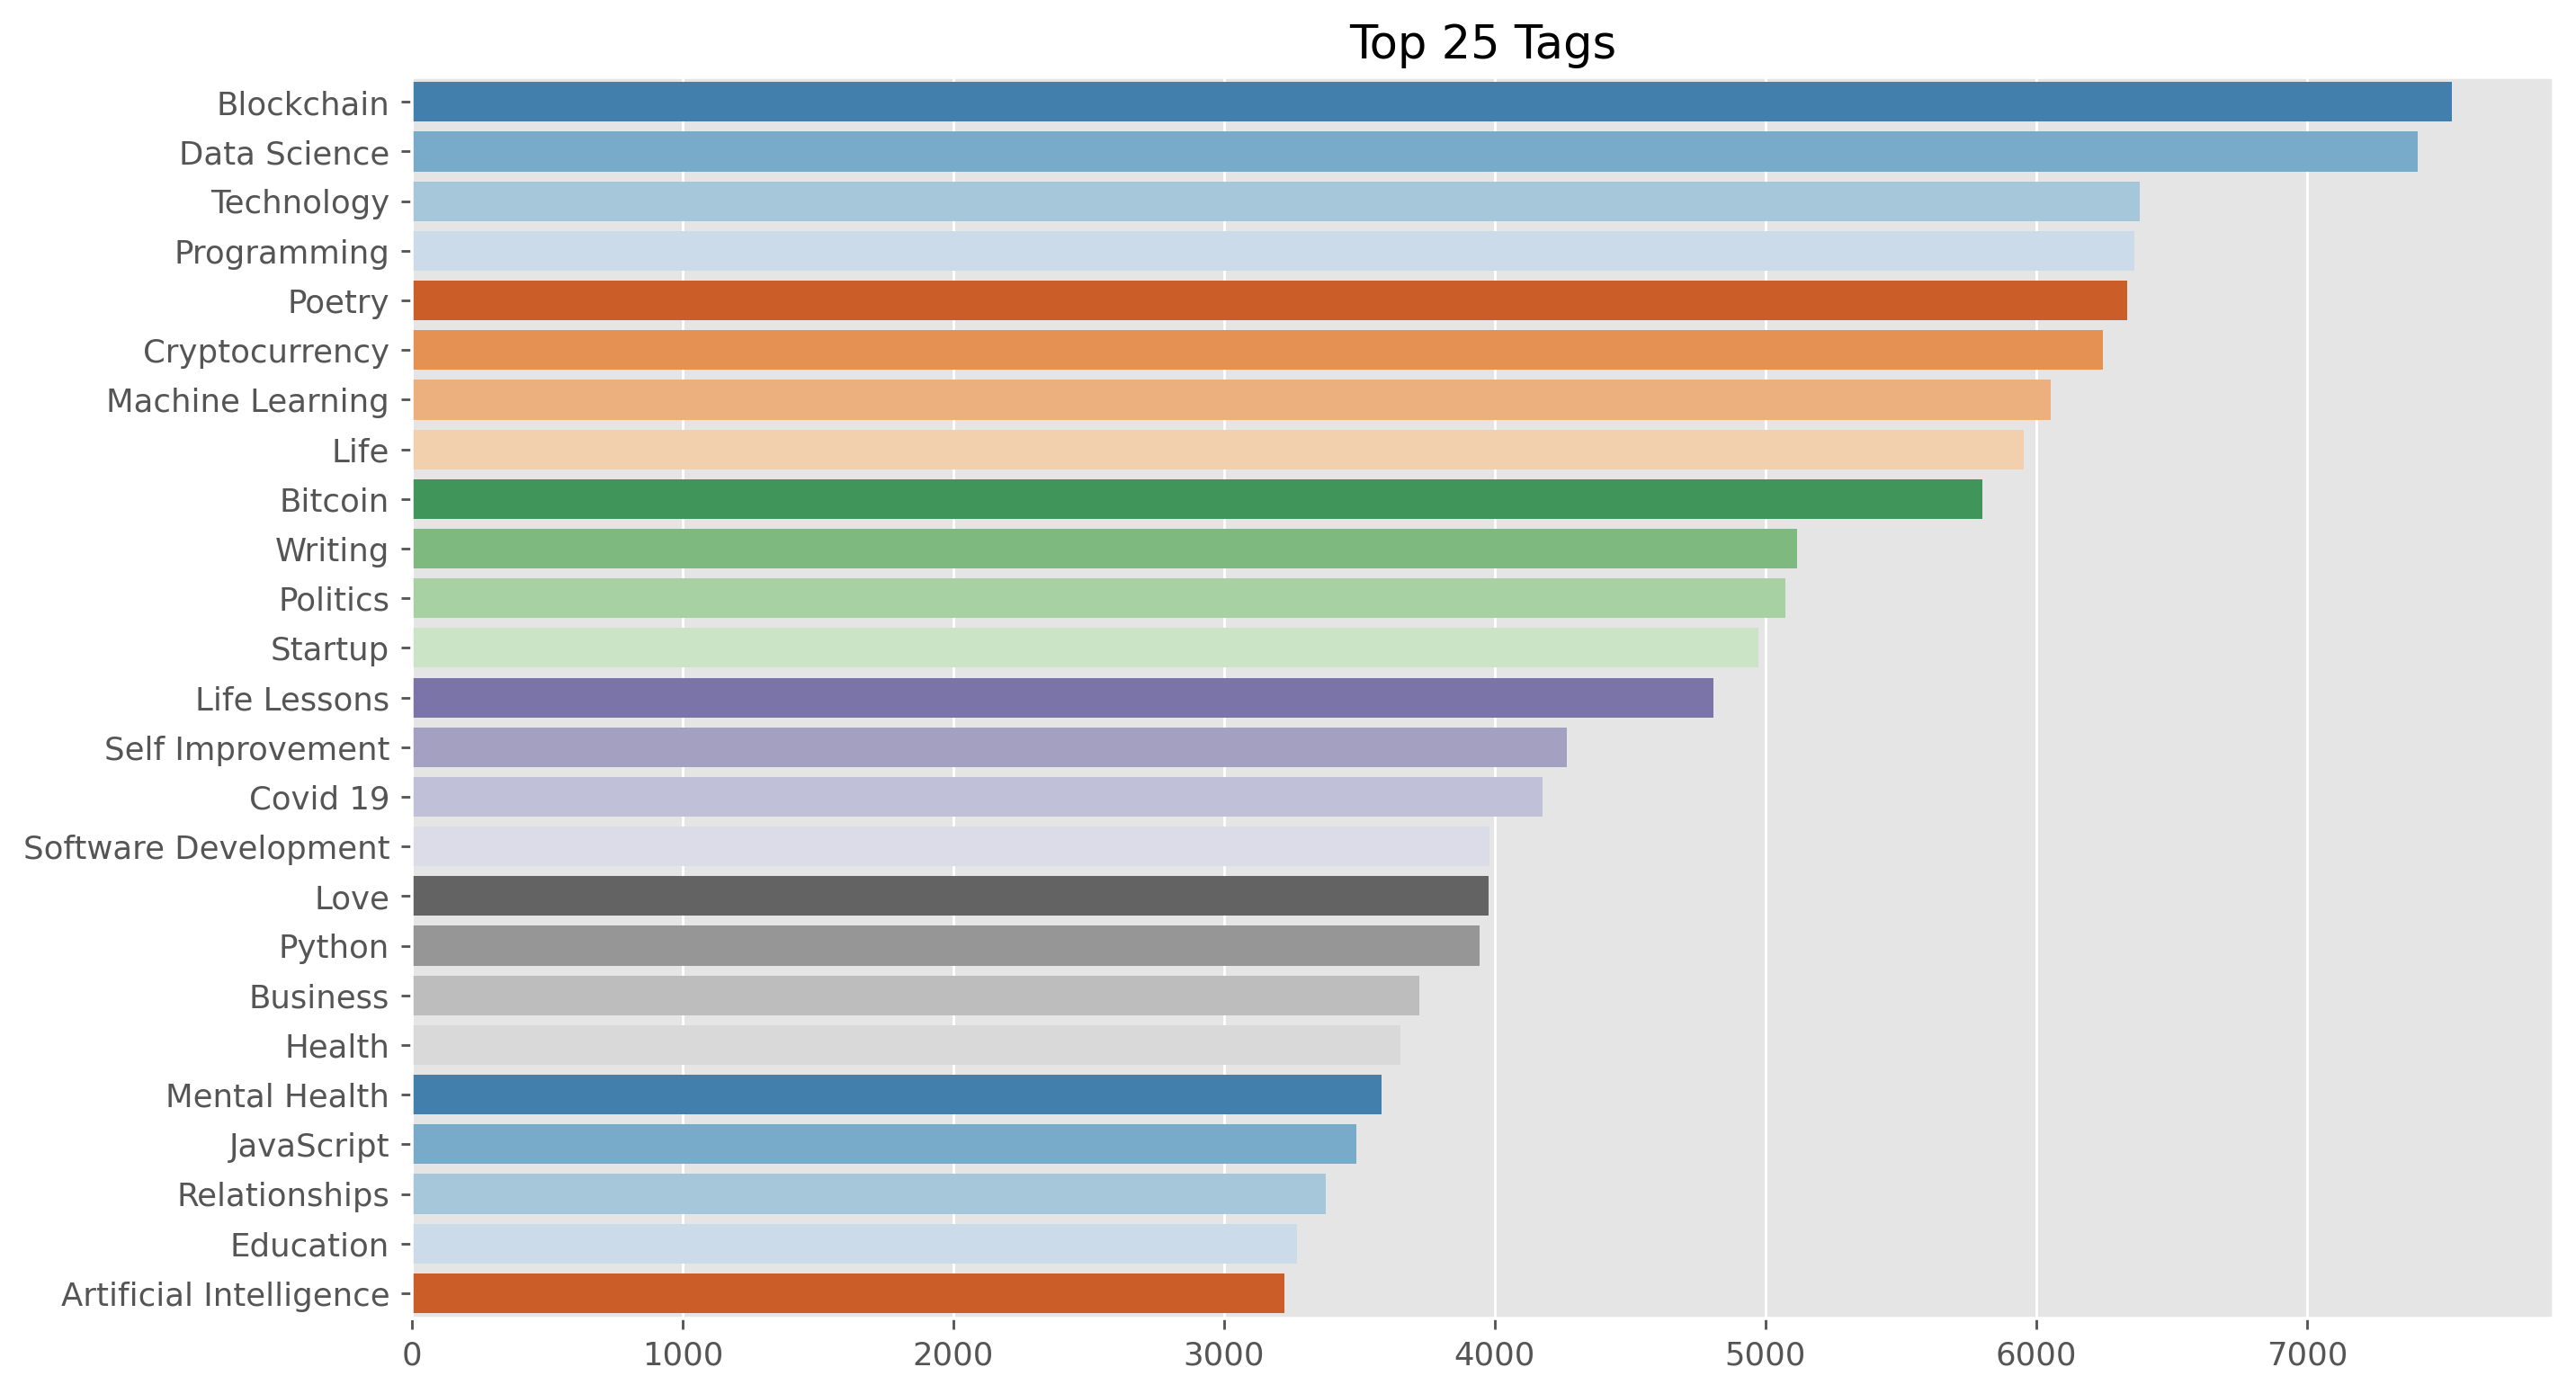

In [94]:
# plot the results 
plt.style.use('ggplot')
figure(num=None, figsize=(12,7), dpi=256, facecolor='w', edgecolor='r')
plt.title("Top 25 Tags") #change to top n tags 
sns.barplot(x = top25.values , y = index , palette = 'tab20c')
plt.show()


## Distribution of collected articles dates

In [95]:
# creating a copy 
df = articles.copy()

In [96]:
# getting the date only from strings
df['timestamp'] = df['timestamp'].str[:10]

In [97]:
df['timestamp'][:5]

0    2020-12-26
1    2020-09-23
2    2020-10-10
3    2020-12-21
4    2020-02-26
Name: timestamp, dtype: object

In [98]:
df['timestamp'] = df['timestamp'].astype('datetime64[ns]')

After visualizing the dates there were some anomalies detected and they must be handled properly


In [99]:
df['timestamp'].dt.year.value_counts()

2020.0    115846
2021.0     32182
2019.0     26221
2018.0      9846
2017.0      4649
2016.0      2689
2015.0       636
2022.0       275
2030.0         5
2009.0         2
2011.0         1
1917.0         1
2014.0         1
1985.0         1
1987.0         1
1991.0         1
2025.0         1
1992.0         1
2077.0         1
2003.0         1
1941.0         1
1969.0         1
2034.0         1
2013.0         1
2012.0         1
Name: timestamp, dtype: int64

Some dates like 2034 or 1917 are clearly anamolies since the timestampe represent the date and time on which the article was published.

According to Wikipedia: "Medium is an American online publishing platform developed by Evan Williams and launched in August 2012."

In [100]:
# filter DataFrame based on date range
start_date = '2012-08-01'
end_date = '2022-12-31'
filtered_df = df.loc[(df['timestamp'] >= start_date) & (df['timestamp'] <= end_date)]


In [101]:
# Group the dates by year and count the number of dates in each group
year_counts = filtered_df['timestamp'].dt.year.value_counts()
year_counts

2020    115846
2021     32182
2019     26221
2018      9846
2017      4649
2016      2689
2015       636
2022       275
2014         1
2013         1
2012         1
Name: timestamp, dtype: int64

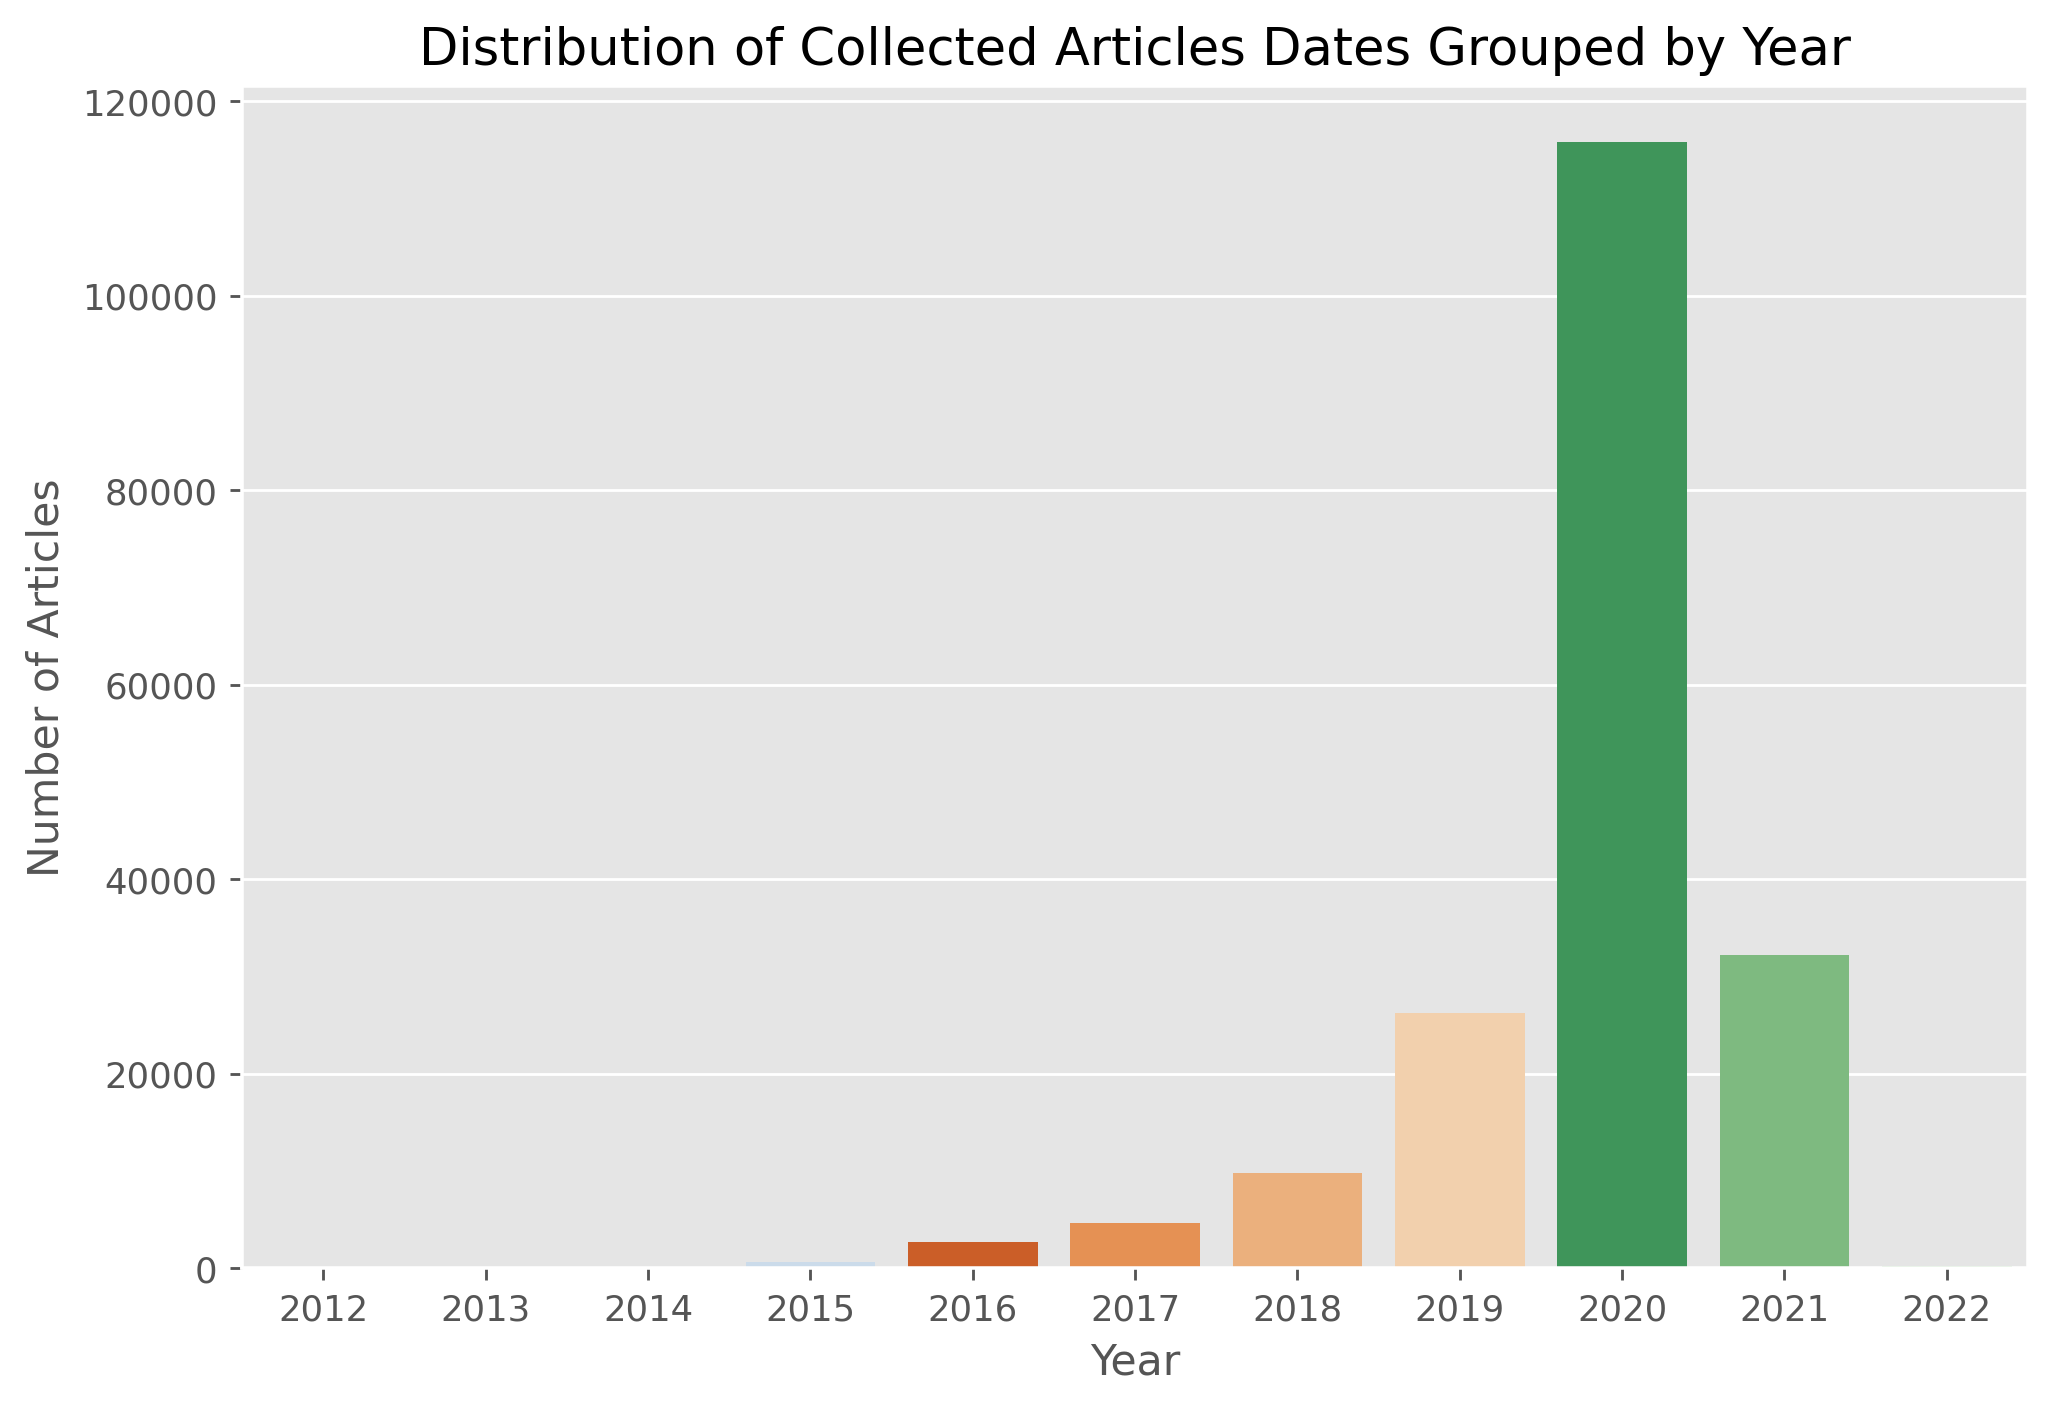

In [102]:
figure(num=None, figsize=(9,6), dpi=256, facecolor='w', edgecolor='r')
# Set the chart title and axis labels
plt.title('Distribution of Collected Articles Dates Grouped by Year')
plt.xlabel('Year')
plt.ylabel('Number of Articles')


# Set the x-axis limits to match the range of the x values
plt.xlim(min(year_counts.index), max(year_counts.index))

sns.barplot(x = year_counts.index, y = year_counts.values , palette = 'tab20c')

plt.show()

## Top 10 Writers

small paragraph here

In [103]:
# get all authors
authors = getListValues('authors')
authors[:5]

[['Ryan Fan'], ['Simon Spichak'], [], ['Eshan Samaranayake'], ['Rishav Sinha']]

In [104]:
authors_count = countValues(authors)

In [105]:
top10 = authors_count.value_counts()[:10]
top10

counts              
Are You Syrious         206
John Au-Yeung           167
The Good Men Project    155
J.D. Harms              152
Scott Myers             143
Gaurav Shah             138
Tds Editors             124
Shamontiel L. Vaughn    122
Martino Pietropoli      115
James Finn              114
dtype: int64

In [106]:
index = top10.index.map(''.join)

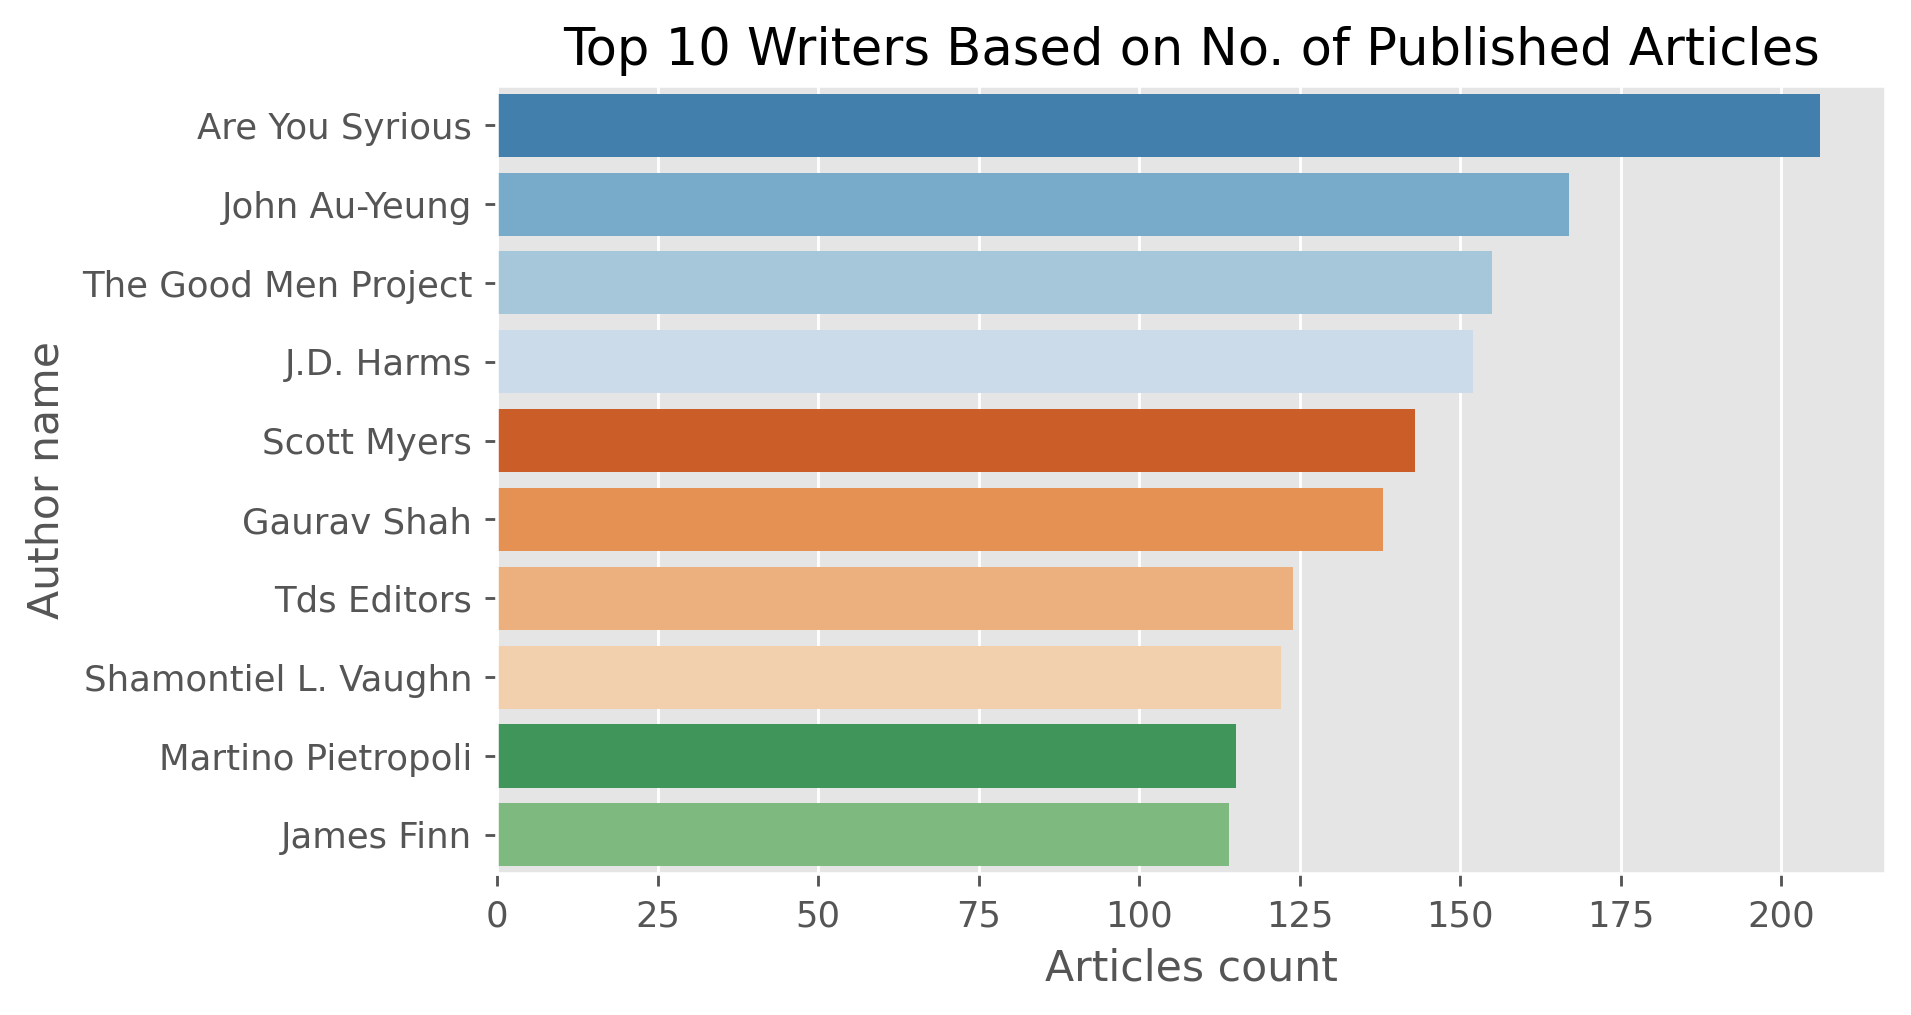

In [107]:
# plot the results 
figure(num=None, figsize=(7,4), dpi=256, facecolor='w', edgecolor='r')
plt.title("Top 10 Writers Based on No. of Published Articles") 

plt.xlabel('Articles count')
plt.ylabel('Author name')

sns.barplot(x = top10.values , y = index , palette = 'tab20c')
plt.show()

# Predictive Modeling

paragraph here

## Preprocessing


### Data Cleaning

to handle a large corpus dataset we can resample the corpus size randomly
other approaches can be using PySpark or any a distributed computing platform

In [54]:
warnings.filterwarnings('ignore')

In [2]:
# sampling to 10.000 articles only
text = pd.read_csv('medium_articles.csv').sample(10000, random_state=42)
text[:3]

,title,text,url,authors,timestamp,tags
51649,2018: Is the Crypto HYPE real?,→ Flagman\n\nIt seems logical to start the inv...,https://medium.com/cc-connecting-crypto-with-b...,[],2018-01-25 10:55:14.696000+00:00,"['Bitcoin', 'Adoption', 'Humor', 'Cryptocurren..."
68568,Liberal Arts Blog — the Brain — What is the Mo...,Liberal Arts Blog — Wednesday is the Joy of Sc...,https://medium.com/@john-muresianu/liberal-art...,['John Muresianu'],2020-12-09 13:57:22.716000+00:00,"['Phisiology', 'Education', 'Liberal Arts Blog..."
176024,Month one is a wrap!! #WenHop,We want to give a huge shout out to our early ...,https://medium.com/@marseconomy/month-one-is-a...,['Mars Economy'],2021-06-17 20:05:16.168000+00:00,"['Entrepreneurship', 'Mars', 'Cryptocurrency',..."


In [3]:
def tokenize(text):
    """
    Description: This function will tokenize, 
    clean the text, and return words to its roots.
  
    Parameters:
    text (str): the function will recive text in str format.
    
    Returns:
    str: clean and tokenized text. 
    
    """
    # normalize text
    text = text.lower() 
    #clean text
    text = re.sub(r'http\S+|https\S+|www\S+|[^0-9A-Za-z \t]', ' ', text)
    #tokenize text using this function
    words = word_tokenize(text) 
    #store stop words 
    stop_words = stopwords.words('english') 
    #remove all stop words
    new_text = [x for x in words if x not in stop_words]
    #lemming
    lemmed = [WordNetLemmatizer().lemmatize(x) for x in new_text]
    return lemmed

In [4]:
text['tokenized'] = text['text'].apply(tokenize)

In [5]:
text['tokenized'][:2]

51649    [flagman, seems, logical, start, investigation...
68568    [liberal, art, blog, wednesday, joy, science, ...
Name: tokenized, dtype: object

## Creating Dictionary and Corpus 

In [40]:
tokenized_text = text['tokenized'].to_list()

# dictrionary to bring original word
dictionary = corpora.Dictionary(tokenized_text)

# Create TDF
corpus = [dictionary.doc2bow(x) for x in tokenized_text]

## Modeling

### LDA

using gensim official documintation: https://radimrehurek.com/gensim/models/ldamodel.html

In [55]:
# building a latent Dirichlet allocation (LDA) topic model using the gensim library
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [56]:
lda_model.print_topics()

[(0,
  '0.030*"data" + 0.022*"0" + 0.021*"1" + 0.018*"model" + 0.012*"value" + 0.012*"x" + 0.011*"2" + 0.009*"word" + 0.008*"3" + 0.007*"feature"'),
 (1,
  '0.014*"data" + 0.014*"system" + 0.010*"service" + 0.008*"user" + 0.008*"use" + 0.007*"information" + 0.007*"also" + 0.007*"technology" + 0.007*"software" + 0.006*"device"'),
 (2,
  '0.013*"code" + 0.011*"file" + 0.009*"create" + 0.008*"use" + 0.008*"name" + 0.008*"url" + 0.007*"app" + 0.007*"user" + 0.007*"using" + 0.007*"function"'),
 (3,
  '0.014*"market" + 0.010*"token" + 0.010*"blockchain" + 0.010*"transaction" + 0.008*"bitcoin" + 0.008*"money" + 0.008*"financial" + 0.007*"contract" + 0.007*"network" + 0.007*"price"'),
 (4,
  '0.011*"content" + 0.011*"website" + 0.010*"business" + 0.010*"customer" + 0.010*"brand" + 0.010*"medium" + 0.010*"google" + 0.010*"product" + 0.009*"online" + 0.009*"marketing"'),
 (5,
  '0.008*"state" + 0.008*"year" + 0.007*"country" + 0.006*"people" + 0.006*"city" + 0.005*"u" + 0.005*"new" + 0.005*"2020

interpting the results: 
https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/


In [57]:
pyLDAvis.enable_notebook()
fig = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(fig)

C:\Users\arwao\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pyLDAvis\_prepare.py:244: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


Text(0.5, 23.52222222222222, 'Topic')

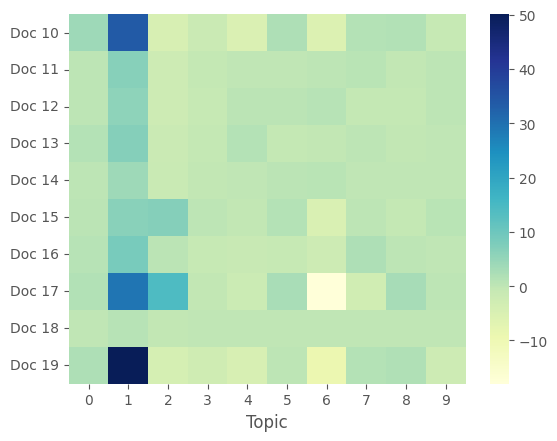

In [114]:
# Get the document-topic distribution from the LsiModel
doc_topic_dist = lsi_model[corpus]

# Convert the document-topic distribution to a matrix
doc_topic_matrix = [[doc_topic[i][1] for i in range(10)] for doc_topic in doc_topic_dist]

# Select a subset of documents to show in the heatmap
start_doc_index = 10
end_doc_index = 20
subset_doc_topic_matrix = doc_topic_matrix[start_doc_index:end_doc_index]

# Get the document labels for the subset of documents
doc_labels = [f"Doc {i}" for i in range(start_doc_index, end_doc_index)]

# Create a heatmap using seaborn
sns.heatmap(subset_doc_topic_matrix, cmap="YlGnBu", yticklabels=doc_labels)

# Set the x- and y-axis labels
plt.xlabel("Topic")

In [56]:
def topic_modeling_pipeline(df=text):
    # Define the vectorizer and the number of topics
    vectorizer = CountVectorizer(tokenizer = tokenize)
    num_topics = 10 # to reduce computational 10 topics are enough for experiment
    num_top_words = 15 
    tokenized_text = text['tokenized'].to_list()
      
    # Create a Gensim Dictionary object from the feature names
    gensim_dict = corpora.Dictionary(tokenized_text)
    
    # Define the three models to be compared
    models = [('LDA', LatentDirichletAllocation(n_components=num_topics)),
              ('NMF', NMF(n_components=num_topics)),
              ('LSA', TruncatedSVD(n_components=num_topics))]

    results = [] #empty list to store scores
    # Define the pipeline for each model and evaluate it
    for name, model in models:
        pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('model', model)
        ])

        # Train the model
        pipeline.fit(text['text'])

        topics = [] #empty list of topics for each model
        topics_table = [] #empty list for topics display
        feature_names = vectorizer.get_feature_names_out() #original dictionary
        for topic_idx, topic in enumerate(model.components_):
            topic_tokens = [feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]
            topics.append(topic_tokens)

        #Print the list of topics
        print(f'List of tokenized topics for {name} Model:')
        for i, topic in enumerate(topics):
          topics_table.append((f'Topic {i}', topic))
        print(pd.DataFrame(topics_table, columns=['Topic No.', 'Top 15 words']).to_string(index=False))
        print()
        # Get the coherence score using Gensim CoherenceModel
        coherence_model = CoherenceModel(model=model,
                                         topics=topics, 
                                          texts=tokenized_text, 
                                          dictionary=gensim_dict,
                                          coherence='c_v')
        
        coherence = coherence_model.get_coherence()
        # Append the results to the list
        results.append((name, coherence))
        
    # Create a pandas dataframe to display the results
    df_results = pd.DataFrame(results, columns=['Model', 'Coherence Score'])

    # Display the dataframe
    print(df_results.to_string(index=False))
        

In [57]:
topic_modeling_pipeline()

List of tokenized topics for LDA Model:
Topic No.                                                                                                               Top 15 words
  Topic 0                                [data, 1, model, 0, value, 2, function, x, using, 3, number, image, use, learning, example]
  Topic 1                       [code, use, user, file, app, need, using, application, test, create, run, new, name, server, system]
  Topic 2                       [one, year, game, movie, film, story, first, child, song, would, music, time, like, show, character]
  Topic 3                                    [time, one, like, people, life, thing, get, know, day, would, make, way, u, want, even]
  Topic 4                       [new, people, work, world, also, year, u, change, team, one, system, time, need, company, community]
  Topic 5                                 [0, token, 1, contract, 2, de, oracle, en, 3, address, 12, 4, transaction, quantum, smart]
  Topic 6                 [pr

# References

Citation

BRIGL, Tobias, 2019, Extracting Reliable Topics using Ensemble Latent Dirichlet Allocation [Bachelor Thesis]. Technische Hochschule Ingolstadt. Munich: Data Reply GmbH. Supervised by Alex Loosley. Available from: https://www.sezanzeb.de/machine_learning/ensemble_LDA/